## Tracking the eastward positive precipitation anomaly

The present method follows the technique of zhang and ling(2017) to identify the MJO events tracking the precipitation anomaly using TRMM datasets.
The method follows three basics steps

## Functions :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset,num2date
from scipy.interpolate import RectBivariateSpline
import seaborn as sns


####################### Function to convert meter/second to day/degree longitude or slope range##########

def convert_day_per_lon(v):  ## meter/second
    
    v_day      = v*3600.*24./(110*1000)  # degree/day
    m_day_deg  =  1./v_day   # rounding upto second decimal
    
    return m_day_deg



################################# Function to generate trial lines:#################################

def trial_lines(x_range,m_range,x_org,time):
    
### x_range : Longitude range
### m_range : slope of the trial lines , note here slope is 1/m as timw y axis
### x_org   : 89.875 E
### y_org   : each time steps
### time_steps : Number of time steps

### output:
### 3D matrix yfit = [slope,predicted_time_ind,time_org/y_org]
    
    y_org     = time

    yfit      = np.zeros((len(x_range),len(m_range),len(y_org)))
    xfit      = np.zeros((len(x_range),len(m_range),len(y_org)))
    
    for t in np.arange(len(y_org)):  
        for i in np.arange(len(m_range)):    
            ytemp             =  m_range[i]*(x_range-x_org)+y_org[t]
            ytemp[ytemp<0.0]  = np.nan
            yfit[:,i,t]       = ytemp
            xfit[:,i,t]       = x_range
    
    return xfit, yfit
        
    
    
#######################function to retain only longest segment ###############################################

def retain_longest_segment(mask,gap):
    istrt = 0
    iend  = mask.shape[0]-1
    imask = mask.astype(int)
    segStart = (np.ones(mask.shape[1:])*-1).astype(int)
    segEnd = (np.ones(mask.shape[1:])*-1).astype(int)
#     fig, ax = plt.subplots(3,1)
    
    for t in np.arange(mask.shape[2]):
        print(t)
        for m in np.arange(mask.shape[1]):
            #do nothing if all values are 1
            if all(mask[:,m,t]):
                segStart[m,t] = istrt
                segEnd[m,t] = iend
                continue
                
            #do nothing if all values are 0    
            if not any(mask[:,m,t]):
                continue
                
            temp = imask[:,m,t]
            df   = pd.DataFrame(list(temp),columns=['A'])
            df['block'] = (df.A.shift(1) != df.A).astype(int).cumsum()
            B = df.reset_index().groupby(['A','block'])['index'].apply(np.array)
                    
            for k in np.arange(B[0].shape[0]):
                zlocs=B[0].iloc[k]
                #do nothing if zero segment occurs at the start or at the end
                if any(zlocs==istrt) or any(zlocs==iend):
                    continue
                    
                #replace with 1 if length zero segment is less than gap
                if len(zlocs)<=gap:
                    temp[zlocs] = 1
            
            
            df   = pd.DataFrame(list(temp),columns=['A'])
            df['block'] = (df.A.shift(1) != df.A).astype(int).cumsum()
            B=df.reset_index().groupby(['A','block'])['index'].apply(np.array)
            
            
            #if only one segment is there, save it back to imask and go to next iteration
            if B[1].shape[0]==1:
                imask[:,m,t]=temp
                wtemp = np.where(temp==1)
                segStart[m,t] = wtemp[0][0]
                segEnd[m,t] = wtemp[0][-1]
                continue
            
            #if more than one segment is there, then retain only the longest segment
            zlen = len(B[1].iloc[0])
            kmax = 0
            
            for k in np.arange(1,B[1].shape[0]):
                if zlen<len(B[1].iloc[k]):
                    zlen = len(B[1].iloc[k])
                    kmax = k
                    
            zlocs = B[1].iloc[kmax]
            temp[:] = 0
            temp[zlocs] = 1
            imask[:,m,t] = temp
            wtemp = np.where(temp==1)
            segStart[m,t] = wtemp[0][0]
            segEnd[m,t] = wtemp[0][-1]
            
    return imask, segStart, segEnd



def find_local_maxima(A,window):
    wnd2=int(window/2)
    strt=wnd2
    endd=A.shape[1]-wnd2
    Amax = np.full(A.shape,False)
    for t in np.arange(strt,endd):
        temp = A[:,t-wnd2:t+wnd2+1]
        Atemp = Amax[:,t-wnd2:t+wnd2+1]
        mval = np.amax(temp)
        Atemp[temp==mval] = True
        Amax[:,t-wnd2:t+wnd2+1] = Atemp  
    return Amax

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def subtract(self, p):
        return Point(self.x - p.x, self.y - p.y)

    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ')'

# calculates the cross product of vector p1 and p2
# if p1 is clockwise from p2 wrt origin then it returns +ve value
# if p2 is anti-clockwise from p2 wrt origin then it returns -ve value
# if p1 p2 and origin are collinear then it returs 0
def cross_product(p1, p2):
    return p1.x * p2.y - p2.x * p1.y

def direction(p1, p2, p3):
    return  cross_product(p3.subtract(p1), p2.subtract(p1))

def left(p1, p2, p3):
    return direction(p1, p2, p3) < 0

def right(p1, p2, p3):
    return direction(p1, p2, p3) > 0

def collinear(p1, p2, p3):
    return direction(p1, p2, p3) == 0

# checks if p lies on the segment p1p2
def on_segment(p1, p2, p):
    return min(p1.x, p2.x) <= p.x <= max(p1.x, p2.x) and min(p1.y, p2.y) <= p.y <= max(p1.y, p2.y)

# checks if line segment p1p2 and p3p4 intersect
def intersect(seg1, seg2):
    p1 = Point(seg1[0],seg1[1])
    p2 = Point(seg1[2],seg1[3])
    p3 = Point(seg2[0],seg2[1])
    p4 = Point(seg2[2],seg2[3])
    
    d1 = direction(p3, p4, p1)
    d2 = direction(p3, p4, p2)
    d3 = direction(p1, p2, p3)
    d4 = direction(p1, p2, p4)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and \
        ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True

    elif d1 == 0 and on_segment(p3, p4, p1):
        return True
    elif d2 == 0 and on_segment(p3, p4, p2):
        return True
    elif d3 == 0 and on_segment(p1, p2, p3):
        return True
    elif d4 == 0 and on_segment(p1, p2, p4):
        return True
    else:
        return False






## Processing

In [29]:
dx            = 0.25 #(in degrees)
dt            = 1. #(in days)
vmin          = 2. # (in m/sec)
vmax          = 10. # (in m/sec)
nlines        = 20
x_org         = 89.875
gap_threshold = 10. #(in degrees)
prop_lim      = 50. # (in degrees)
speed_lim     = [3,7] #(m/s)
day_lim       = 20 #(20 days)


v_range       = np.linspace(vmin,vmax,nlines)

m_range       = convert_day_per_lon(v_range)

gap           = int(gap_threshold/dx)

iprop_lim     = int(prop_lim/dx)
ispeed_lim    = np.where(np.logical_and(v_range>=speed_lim[0],v_range<=speed_lim[1]))[0][[0,-1]]
iday_lim      = int(day_lim/dt)

dataset       = Dataset('MJO_filtered.nc')

var           = dataset.variables['mjo_time_lon'][:]
lon           = dataset.variables['lon'][:]
time          = dataset.variables['time'][:]

maxtim        = int(dx*lon.size*m_range[0])
imaxtim       = int(maxtim/dt)

print(maxtim)

#Initialize interpolation
interp_spline = RectBivariateSpline(time, lon, var)

#Initialize trial lines
tlx, tly      = trial_lines(lon,m_range,x_org,time)

#Do interpolation onto trial lines

P           = interp_spline(tly,tlx,grid=False)

print(P.shape)

stddata       = Dataset('MJO_filtered_std.nc')
sigma         = stddata['mjo_time_lon'][:]

178
(1120, 20, 366)


In [3]:
mask  = np.full(P.shape, False)

for i in np.arange(sigma.size):
    mask[i,:,:] = P[i,:,:]>=sigma[i]

imask, segStart, segEnd = retain_longest_segment(mask,gap)


A = np.nansum(P*imask,0)

window=11

Amax = find_local_maxima(A,window)
Amax.shape



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(20, 366)

247


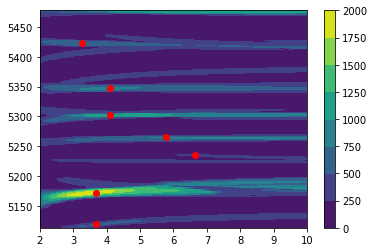

In [30]:
var1=np.zeros(var.shape)
for i in np.arange(var.shape[0]):
    var1[i,:]=(var[i,:]>=sigma)*1

segStart = segStart.astype(int)
segEnd = segEnd.astype(int)

segEndpts = np.ones((np.sum(Amax),4))
segTval = np.ones(np.sum(Amax)).astype(int)
segMval = np.ones(np.sum(Amax)).astype(int)

k=0

for t in np.arange(Amax.shape[1]):
    for m in np.arange(Amax.shape[0]):
        if not Amax[m,t]:
            continue
        #print(tly[segStart[m,t],m,t])
        segEndpts[k,0] = lon[segStart[m,t]]
        segEndpts[k,1] = tly[segStart[m,t],m,t]
        segEndpts[k,2] = lon[segEnd[m,t]]
        segEndpts[k,3] = tly[segEnd[m,t],m,t]
        segTval[k] = t
        segMval[k] = m
        k = k + 1

isrt = segTval.argsort()
segTval = segTval[isrt]
segMval = segMval[isrt]
segEndpts = segEndpts[isrt,:]

Epts = segEndpts.tolist()
Tval = segTval.tolist()
Mval = segMval.tolist()

print(len(Epts))

segVld = []
while len(Epts)>1:
    idel = []
    seg1 = Epts[0]
    m1 = Mval[0]
    t1 = Tval[0]
    del Epts[0]
    del Mval[0]
    del Tval[0]
    iseg1 = np.arange(segStart[m1,t1],segEnd[m1,t1]+1)
    if iseg1.size < iprop_lim:
        continue
    if m1 < ispeed_lim[0] or m1 > ispeed_lim[1]:
        continue
        
    k = -1
    valid = True
    for (seg2, m2, t2) in zip(Epts,Mval,Tval):
        k = k + 1
        if intersect(seg1,seg2):
            if (A[m1,t1]>A[m2,t2]):
                idel.append(k)
            else:
                valid = False
                break
        elif ((seg2[1]-seg1[1])<iday_lim):
            if (A[m1,t1]>A[m2,t2]):
                idel.append(k)
            else:
                valid = False
                break
        else:
            iseg2 = np.arange(segStart[m2,t2],segEnd[m2,t2]+1)
            iseg  = np.intersect1d(iseg1,iseg2)
            if iseg.size:               
                segX = lon[iseg]
                segY1 = tly[iseg,m1,t1]
                segY2 = tly[iseg,m2,t2]
                connected=False
                for i in np.arange(iseg.size):
                    sy1 = segY1[i]
                    sy2 = segY2[i]
                    iy=np.where(np.logical_and(time>=sy1,time<=sy2))[0]
                    if all(var1[iy,iseg[i]]): #single envelope
                        connected=True
                        break
                if connected:
                    if (A[m1,t1]>A[m2,t2]):
                        idel.append(k)
                    else:
                        valid = False
                        break
        
        if (m2-m1)>imaxtim:
                break
    if valid:
        segVld.append([m1,t1])
    
    for index in sorted(idel, reverse=True):
        del Epts[index]
        del Mval[index]
        del Tval[index]


        
segVldr=np.array(segVld)

plt.contourf(v_range,time,A[:,:].T)
plt.plot(v_range[segVldr[:,0]],time[segVldr[:,1]],'ro')
plt.colorbar();

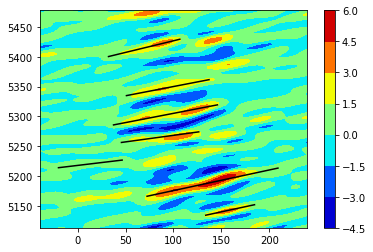

In [31]:
nmask=imask*1.
nmask[imask==0]=np.nan

im=plt.contourf(lon,time,var,cmap='jet')

plt.colorbar()

#plt.plot(tlx[:,5,234]*nmask[:,5,234],tly[:,5,234]*nmask[:,5,234],'k')
#plt.plot(tlx[:,6,236]*nmask[:,6,236],tly[:,6,236]*nmask[:,6,236],'k')
for [i,j] in segVld:
    plt.plot(tlx[:,i,j]*nmask[:,i,j],tly[:,i,j]*nmask[:,i,j],'k')
#plt.plot(segStartx,segStarty,'ro')
#plt.plot(segEndx,segEndy,'ro')
#plt.ylim(5100,5250)